# Preparation

## Import

In [3]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow import keras
from tensorflow.keras import layers
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


**AUTOTUNE**: 

* **map**: transform the dataset according to a function, in this case converts the images to float
* **cache**: keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
* **prefetch**: for optimization porpuses 

## Functions

In [ ]:
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

### create dataset

In [ ]:
def create_train_dataset(training_dir, batch_size = 32, greyscale = True):

    color = 'grayscale'
    if(not greyscale):
        color = 'rgb'

    # for fitting 
    train_ds = tf.keras.utils.image_dataset_from_directory(
        training_dir,
        seed=420,
        image_size=(img_height, img_width),
        batch_size= batch_size,
        validation_split=0.2,
        subset="training",
        color_mode=color,
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        training_dir,
        seed=420,
        image_size=(img_height, img_width),
        batch_size= batch_size,
        validation_split=0.2,
        subset="validation",
        color_mode= color,
    )




    AUTOTUNE = tf.data.experimental.AUTOTUNE

    ds_train = train_ds.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE)
    ds_valid = val_ds.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE)
   
    class_names = train_ds.class_names

    

    return (ds_train, ds_valid, class_names)



def create_test_dataset( query_ds, gallery_ds,  batch_size = 32, greyscale = True):
    color = 'grayscale'
    if(not greyscale):
        color = 'rgb'   

    query_ds = tf.keras.utils.image_dataset_from_directory(
        query_dir,
        seed=420,
        image_size=(img_height, img_width),
        batch_size= batch_size,
        color_mode= color,
    )

    gallery_ds = tf.keras.utils.image_dataset_from_directory(
        gallery_dir,
        seed=420,
        image_size=(img_height, img_width),
        batch_size= batch_size,
        color_mode= color,
    )

    AUTOTUNE = tf.data.experimental.AUTOTUNE

    ds_query = query_ds.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE)
    ds_gallery = gallery_ds.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE)

    return (ds_query, ds_gallery)

### print 16 images

In [ ]:
def print_16_imgs(dataset):
    imgs = np.concatenate([x for x, y in dataset], axis=0)
    labels = np.concatenate([y for x, y in dataset], axis=0)

    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(imgs[i].astype('uint8'), cmap=plt.cm.binary)
        plt.grid(False)
        plt.title(class_names[labels[i]])



### create model

In [4]:
def create_model():

    data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=(img_height, img_width, img_depth)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
    )


    model = keras.Sequential([

        data_augmentation,
        layers.Rescaling(1./255), # only with rgb

        layers.Conv2D(32, 3, padding='same', activation='relu' ),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, padding='same', activation='relu'), # relu for hidden layers
        layers.MaxPooling2D(),

        layers.Dropout(0.3),
        layers.Flatten(),
        #layers.Dense(16),
        layers.Dense(32, activation='relu'),
       # layers.Dense(10, activation='softmax') # softmax for probablities 


    ])

    model.compile(
        optimizer='adam',
        loss= tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'],
    )

    model.build((None, img_width, img_height, img_depth))


    model.summary()
    return model



## Parameters

In [5]:
img_height = 128
img_width = 128
img_depth = 3 # 1 if greyscale 3 if rgb
n_epochs = 10

# Dataset and model

## Dataset directories

In [6]:
# drive 
training_dir = pathlib.Path('/datasets/animali/animals_dataset_the_ostriches/animals_dataset/training')
query_dir = pathlib.Path('/datasets/animali/animals_dataset_the_ostriches/animals_dataset/validation2/query')
gallery_dir = pathlib.Path('/datasets/animali/animals_dataset_the_ostriches/animals_dataset/validation2/gallery')
#local
#training_dir = pathlib.Path('/work/dataset/training')
#query_dir = pathlib.Path('/work/dataset/validation/query')
#gallery_dir = pathlib.Path('/work/dataset/validation/gallery')



## Create dataset and fit the model

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size=(img_height, img_width),
        batch_size=32,
        #class_mode='binary'
        )


model = create_model()

model.fit(train_generator,
        steps_per_epoch=2000,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800)



Found 16607 images belonging to 10 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)      

NameError: name 'validation_generator' is not defined

In [ ]:
train,val, class_names = create_train_dataset(training_dir, greyscale=False)

model = create_model()

history = model.fit(
    train.take(100),
    validation_data=val,
    epochs= 20,
)

KeyboardInterrupt: 

# Evaluation and prediction

## Functions

### Get rank 

In [ ]:
# given a prediction sorts according to the probabilities and returns a list of tuples (1, 0.2)
# the tuple (1, 0.2) means that class 1 has 0.2 % of probability
def get_sorted_prediction(predictions):
    a = np.argsort(predictions)[::-1] # sorted indexes 
    b = sorted(predictions)[::-1] # sorted probabilities 
    return zip(a,b)

# this func is called for each query image return 10 element of the gallery (by their index)
def get_rank(query_pred, gallery_pred):

    # sort the 
    query = list(get_sorted_prediction(query_pred)) # query

    #gallery 
    gallery = {}
    for i, pred in enumerate(gallery_pred):
        gallery[i] = (list(get_sorted_prediction(pred)))

    ranking = []

    # iterate starting from the most probable class and find a match in the gallery 
    for class_number in query:
        maxi = 0
        max_idx = 99
        for i, pred in gallery.items():
            if class_number[0] == pred[0][0]:
                if maxi < pred[0][1]:
                    maxi = pred[0][1]
                    max_idx = i
        

        if maxi > 0:
            ranking.append(max_idx)

    return ranking



## Evaluate

In [ ]:
query, gallery = create_test_dataset(query_dir, gallery_dir, greyscale=False)

model.evaluate(query)

Found 100 files belonging to 10 classes.
Found 4992 files belonging to 10 classes.
4/4 [==============================] - 4s 179ms/step - loss: 1.5744 - accuracy: 0.4700


[1.5743736028671265, 0.4699999988079071]

## Ranking

In [ ]:

query_pred = model.predict(query)  # 
gallery_pred = model.predict(gallery.take(5)) # take(5) takes the first 5 batches

In [ ]:
rankings = []
for pred in query_pred:
    rankings.append(get_rank(pred, gallery_pred))


In [ ]:
rankings[0]
class_names[np.argmax(query_pred[0])]

'goldfish'

Text(0.5, 1.0, 'peacock pred: peacock')

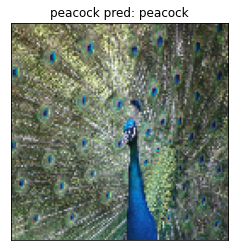

In [ ]:
imgs = np.concatenate([x for x, y in query.take(1)], axis=0)
labels = np.concatenate([y for x, y in query.take(1)], axis=0)

i = 23

plt.xticks([])
plt.yticks([])
plt.imshow(imgs[i].astype('uint8'), cmap=plt.cm.binary)
plt.grid(False)
plt.title(class_names[labels[i]] + " pred: "+ class_names[np.argmax(query_pred[i])])





In [ ]:
gallery_imgs = np.concatenate([x for x, y in gallery.take(5)], axis=0)
gallery_labels = np.concatenate([y for x, y in gallery.take(5)], axis=0)

for j in rankings[i]:
    print(j)

150
155
9
81
74
29
107
94
135
97


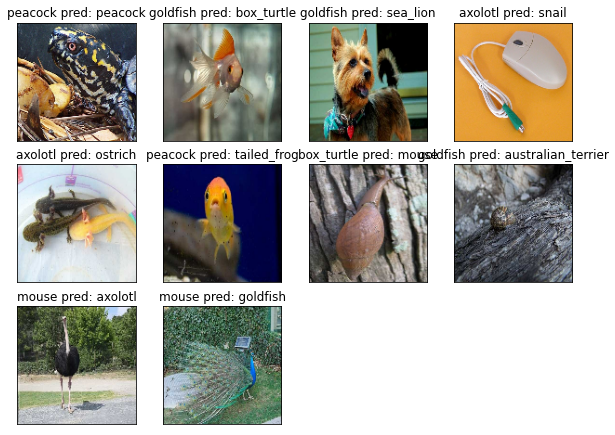

In [ ]:
plt.figure(figsize=(10,10))
c=0
for j in rankings[i]:
    plt.subplot(4,4,c+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(gallery_imgs[j].astype('uint8'), cmap=plt.cm.binary)
    plt.grid(False)
    plt.title(class_names[gallery_labels[j]] + " pred: "+ class_names[np.argmax(gallery_pred[j])])
    c+=1


In [ ]:
choice = tf.data.Dataset.from_tensors([3,4,6])
choice_dataset = tf.data.Dataset.range(3).repeat(3)

result = tf.data.Dataset.choose_from_datasets(gallery, choice_dataset)

result

KeyboardInterrupt: 

In [ ]:
gallery.get_single_element()

InvalidArgumentError: Dataset had more than one element. [Op:DatasetToSingleElement]

Text(0.5, 1.0, 'peacock pred: peacock')

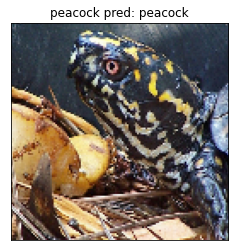

In [ ]:
j = 150

plt.xticks([])
plt.yticks([])
plt.imshow(gallery_imgs[j].astype('uint8'), cmap=plt.cm.binary)
plt.grid(False)
plt.title(class_names[gallery_labels[j]] + " pred: "+ class_names[np.argmax(gallery_pred[j])])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=93aceac2-8452-469e-8b02-c16d0438aa9c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>